### Bayesian Poisson regression with PyMC3

In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import theano.tensor as ts
import pymc3 as pm

import utils

seed = 504887
plt.style.use("bmh")
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [3]:
data_path = os.path.join("data", "wine_quality.csv")
wine = pd.read_csv(data_path, delimiter=";")
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


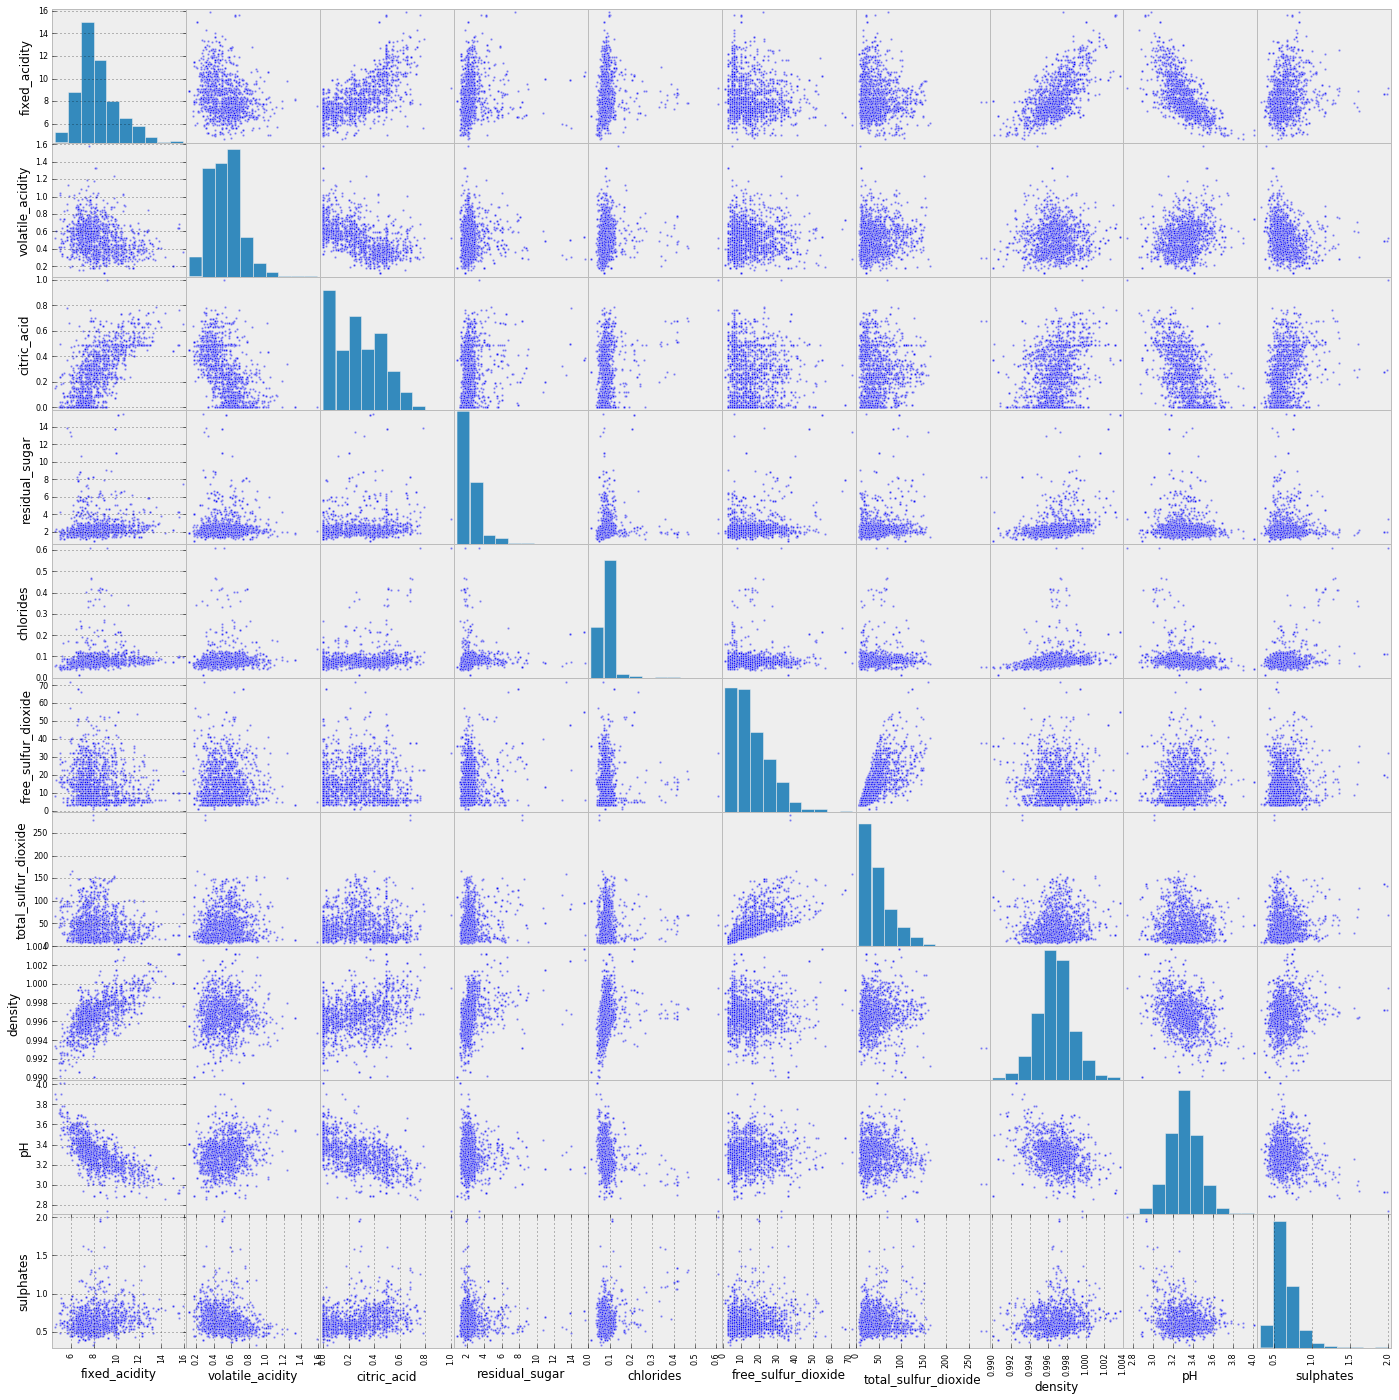

In [15]:
_ = pd.scatter_matrix(wine[wine.columns[:-2]], figsize=(24,24))

<Container object of 6 artists>

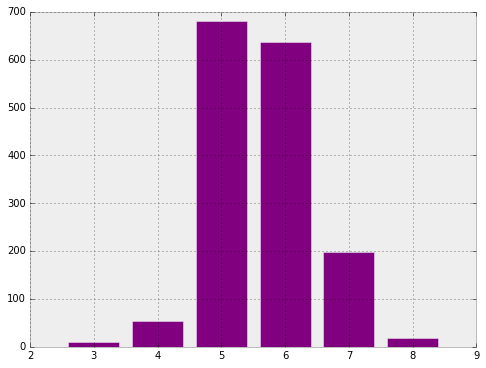

In [10]:
vals,counts = utils.count(wine.quality.values)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.bar(vals, counts, color="purple", align="center")

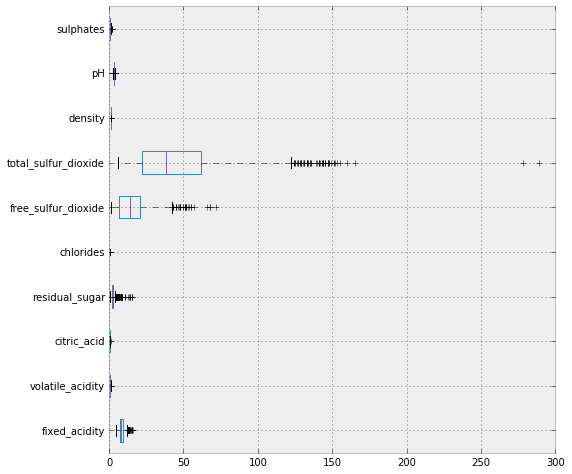

In [12]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
_= wine[wine.columns[:-2]].boxplot(ax=ax, vert=False)

In [4]:
wine.columns = list(map(lambda s: s.replace(" ","_"), wine.columns))
wine.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [5]:
fa = wine.fixed_acidity.values
va = wine.volatile_acidity.values
ca = wine.citric_acid.values
rs = wine.residual_sugar.values
ch = wine.chlorides.values
fs = wine.free_sulfur_dioxide.values
td = wine.total_sulfur_dioxide.values
dn = wine.density.values
ph = wine.pH.values
sp = wine.sulphates.values
al = wine.alcohol.values
qy = wine.quality.values

data = np.c_[fa,va,ca,rs,ch,fs,td,dn,ph,sp,al]

In [6]:
n,m = data.shape

In [7]:
with pm.Model() as pois_reg:
    alpha = pm.Normal("alpha", mu=0, sd=1, testval=np.random.randn())
    beta = pm.Normal("beta", mu=0, sd=1, shape=m, testval=np.random.randn(m))
    lamda = pm.Deterministic("lamda", alpha + ts.dot(data,beta))
    like = pm.Poisson("like", mu=lamda, observed=qy)

In [8]:
pois_reg.vars

[alpha, beta]

In [9]:
with pois_reg:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_pois_reg = pm.sample(2000, step=step, start=start)

 [-----------------100%-----------------] 2001 of 2000 complete in 100.2 sec

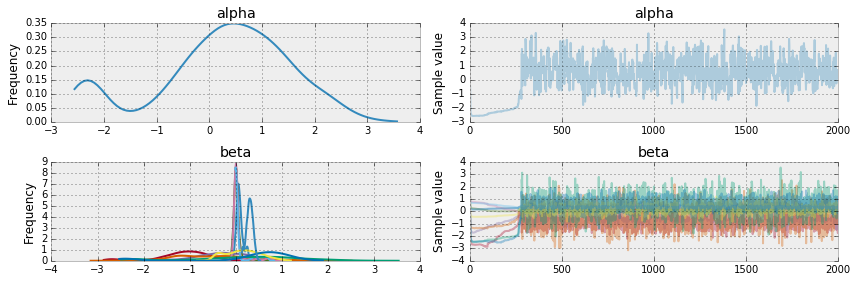

In [10]:
_ = pm.traceplot(trace_pois_reg, varnames=["alpha","beta"])

In [13]:
trace_pois_reg["lamda"].mean(0)

array([ 6.7829829 ,  9.81963312,  8.45837727, ...,  8.88079653,
        8.90954886,  8.46451716])

In [12]:
trace_pois_reg["beta"].mean(0)

array([ 0.08691081, -1.13476923, -0.28909435,  0.01734516, -0.49583918,
        0.05909906,  0.0686364 ,  0.1543247 ,  0.15149979,  0.31642986,
        0.30417703])

In [14]:
nsamples = 100
ppc = pm.sample_ppc(trace_pois_reg, samples=nsamples, model=pois_reg, vars=[like])

In [15]:
ppc["like"]

array([[8, 2, 8, ..., 3, 9, 6],
       [4, 5, 4, ..., 5, 5, 4],
       [3, 8, 5, ..., 5, 6, 3],
       ..., 
       [9, 4, 4, ..., 5, 7, 8],
       [3, 4, 5, ..., 9, 7, 5],
       [3, 4, 7, ..., 6, 3, 6]])

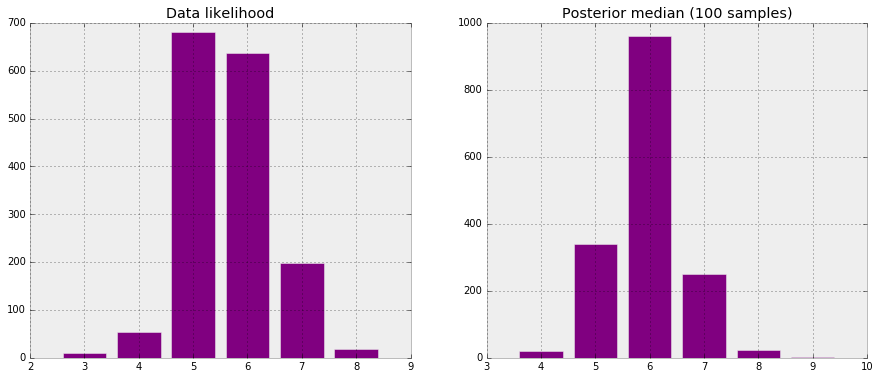

In [16]:
fig = plt.figure(figsize=(15,6))

vals,counts = utils.count(wine.quality.values)
ax = fig.add_subplot(121)
ax.bar(vals, counts, color="purple", align="center")
ax.set_title("Data likelihood")

vals,counts = utils.count(np.round(np.median(ppc["like"], 0)))
ax = fig.add_subplot(122)
ax.bar(vals, counts, color="purple", align="center")
ax.set_title("Posterior median (%d samples)" % nsamples)